In [3]:
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
# import constants_sf as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = 2017
future_year = 2050
us_ton_to_ton = 0.907185
miles_to_km = 1.60934
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)

future_load_attr = 'tons_' + str(future_year)
future_tonmile_attr = 'tmiles_' + str(future_year)

plot_dir = 'plots_Seattle/'
output_dir = 'outputs_Seattle/'

region_code = [531, 532, 411, 539]

In [9]:
#load FAF data

faf_data = read_csv('Validation/' + 'FAF5.3.csv', sep = ',')
#load parameters
sctg_group_lookup = read_csv('SynthFirm_parameters/' + 'SCTG_Groups_revised_V2.csv', sep = ',')
cfs_faf_lookup = read_csv('SynthFirm_parameters/' + 'CFS_FAF_LOOKUP.csv', sep = ',')
# sctg_definition = read_csv('SynthFirm_parameters/' + 'SCTG_definition.csv', sep = ',')
sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
# faf_data = pd.merge(faf_data, sctg_definition, left_on = 'sctg2', right_on = 'SCTG', how = 'left')
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
faf_outflow = faf_data.loc[faf_data['dms_orig'].isin(region_code)]
faf_inflow = faf_data.loc[faf_data['dms_dest'].isin(region_code)]
trade_type_id = 1 # domestic only
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == trade_type_id]

In [10]:
# calculate unit cost from FAF
shipment_value_attr = 'value_' + str(analysis_year)

unit_cost_by_sctg = \
faf_data_domestic.groupby(['sctg2'])[[shipment_value_attr, shipment_load_attr]].sum()
unit_cost_by_sctg = unit_cost_by_sctg.reset_index()
unit_cost_by_sctg.loc[:, 'UnitCost'] = \
unit_cost_by_sctg.loc[:, shipment_value_attr] * 1000/ \
unit_cost_by_sctg.loc[:, shipment_load_attr] 
unit_cost_by_sctg.head(5)

unit_cost_by_sctg = unit_cost_by_sctg[['sctg2', 'UnitCost']]
unit_cost_by_sctg = \
unit_cost_by_sctg.rename(columns = {'sctg2': 'Commodity_SCTG'})
unit_cost_by_sctg.to_csv('SynthFirm_parameters/' + \
                         'data_unitcost_faf5.csv', index = False)

In [11]:
unit_cost_by_sctg_zone = \
faf_data_domestic.groupby(['dms_orig', 'sctg2'])[[shipment_value_attr, shipment_load_attr]].sum()
unit_cost_by_sctg_zone = unit_cost_by_sctg_zone.reset_index()
unit_cost_by_sctg_zone.loc[:, 'UnitCost'] = \
unit_cost_by_sctg_zone.loc[:, shipment_value_attr] * 1000/ \
unit_cost_by_sctg_zone.loc[:, shipment_load_attr] 
# unit_cost_by_sctg_zone.head(5)

unit_cost_by_sctg_zone = pd.merge(unit_cost_by_sctg_zone,
                                  cfs_faf_lookup,
                                 left_on = 'dms_orig',
                                 right_on = 'FAF',
                                 how = 'left')
unit_cost_by_sctg_zone.head(5)
unit_cost_by_sctg_zone = \
unit_cost_by_sctg_zone[['sctg2', 'ST_MA', 'FAF', 'SHORTNAME', 'UnitCost']]
unit_cost_by_sctg_zone = \
unit_cost_by_sctg_zone.rename(columns = {'sctg2': 'Commodity_SCTG',
                                        'ST_MA': 'ORIG_CFS_AREA'})
unit_cost_by_sctg_zone.to_csv('SynthFirm_parameters/' + \
                         'data_unitcost_by_zone_faf5.csv', index = False)


In [3]:
# get domestic/international ratio
# print(faf_outflow.columns)
trade_type_lookup = {1: 'Domestic Only', 2: 'Import', 3: 'Export'}
outflow_by_trade = \
faf_outflow.groupby(['trade_type', 'SCTG_Name'])[[shipment_load_attr]].sum()

outflow_by_trade = outflow_by_trade.reset_index()
outflow_by_trade.loc[:, 'type'] = 'Outbound'
outflow_by_trade.loc[:, 'trade'] = \
outflow_by_trade.loc[:, 'trade_type'].map(trade_type_lookup)
inflow_by_trade = \
faf_inflow.groupby(['trade_type', 'SCTG_Name'])[[shipment_load_attr]].sum()
inflow_by_trade = inflow_by_trade.reset_index()
inflow_by_trade.loc[:, 'type'] = 'Inbound'
inflow_by_trade.loc[:, 'trade'] = \
inflow_by_trade.loc[:, 'trade_type'].map(trade_type_lookup)

final_flow_by_trade = pd.concat([outflow_by_trade, inflow_by_trade])

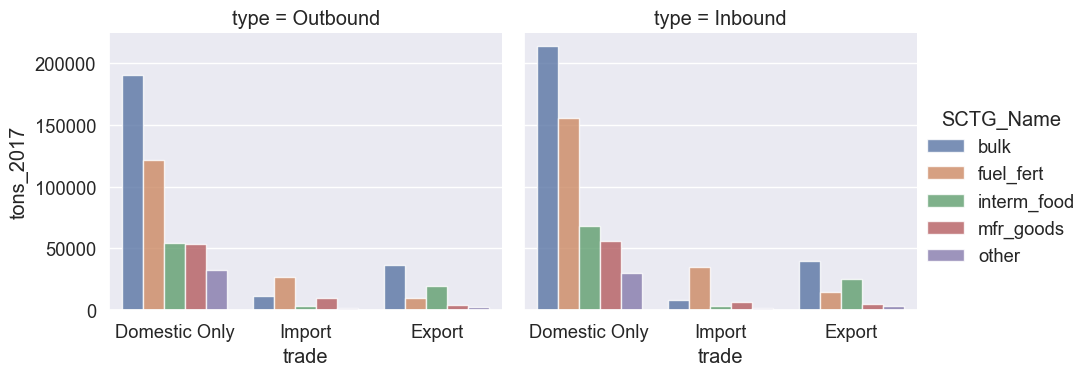

In [4]:
sns.catplot(
    data= final_flow_by_trade, kind="bar",
    x="trade", y=shipment_load_attr, hue = 'SCTG_Name',
    col = 'type', col_wrap = 2,
    alpha=.8, height=4, aspect=1.2
)
plt.savefig(plot_dir + 'FAF_load_by_trade_type.png', dpi = 300)
plt.show()
final_flow_by_trade.to_csv(output_dir + 'FAF_load_by_trade_type.csv')

In [4]:
# faf name lookup 
faf_name_lookup = read_csv('SynthFirm_parameters/' + 'FAF_NAME_LOOKUP.csv')
faf_name_lookup.columns = ['FAFID', 'FAFNAME']
faf_name_lookup['FAFID'] = faf_name_lookup['FAFID'].astype(int)
faf_name_lookup.head(5)

,FAFID,FAFNAME
0,11,Birmingham
1,12,Mobile
2,19,Rest of AL
3,20,Alaska
4,41,Phoenix


In [ ]:
# top destinations
nzones = 20
faf_outflow.loc[:, 'dest'] = faf_outflow.loc[:, 'dms_dest']
faf_outflow.loc[faf_outflow['trade_type'] == 3, 'dest'] = \
faf_outflow.loc[:, 'fr_dest']
faf_outflow.loc[:, 'dest'] = faf_outflow.loc[:, 'dest'].astype(int)
agg_faf_outflow_by_destination = faf_outflow.groupby(['dest'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_faf_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination,
                                         faf_name_lookup,
                                         left_on = 'dest',
                                         right_on = 'FAFID',
                                         how = 'left')

agg_faf_outflow_by_destination = \
agg_faf_outflow_by_destination.sort_values(shipment_load_attr, ascending = False)
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.head(nzones)
ax = agg_faf_outflow_by_destination.plot.barh(x = 'FAFNAME', 
                                              y = shipment_load_attr, 
                                         figsize = (7,10), rot = 0)
# vals = ax.get_xticks()
# ax.set_xticklabels(['{:,.1%}'.format(x) for x in vals])
plt.xlabel('Tonnage')
plt.ylabel('')
plt.savefig(plot_dir + 'FAF_outflow_load_by_top_dest.png', bbox_inches = 'tight', dpi = 200)
plt.show()

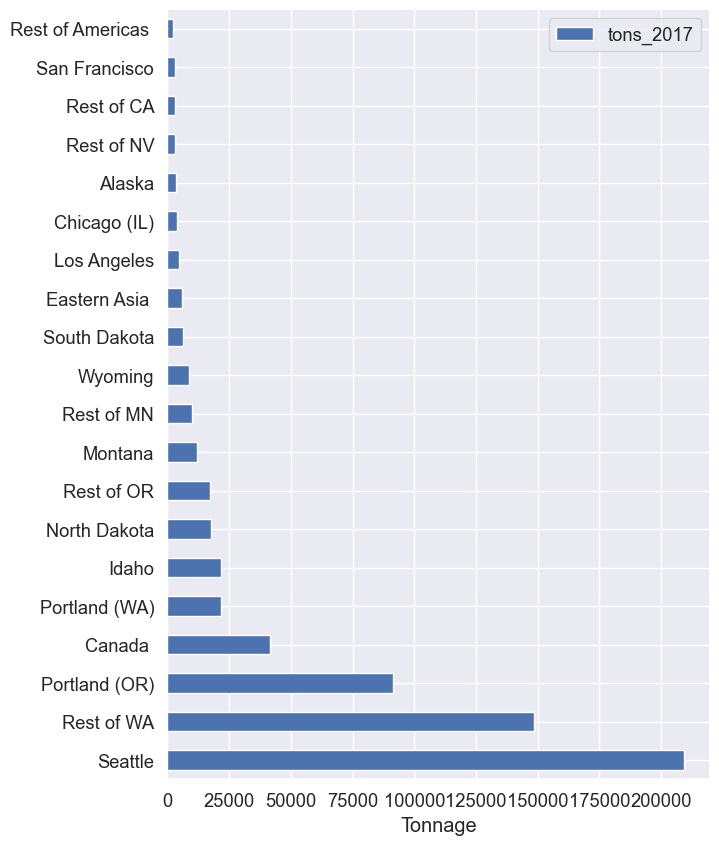

In [7]:
# top origins
nzones = 20
faf_inflow.loc[:, 'origin'] = faf_inflow.loc[:, 'dms_orig']
faf_inflow.loc[faf_inflow['trade_type'] == 2, 'origin'] = \
faf_inflow.loc[:, 'fr_orig']
faf_inflow.loc[:, 'origin'] = faf_inflow.loc[:, 'origin'].astype(int)
agg_faf_inflow_by_destination = faf_inflow.groupby(['origin'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_destination = agg_faf_inflow_by_destination.reset_index()
agg_faf_inflow_by_destination = pd.merge(agg_faf_inflow_by_destination,
                                         faf_name_lookup,
                                         left_on = 'origin',
                                         right_on = 'FAFID',
                                         how = 'left')

agg_faf_inflow_by_destination = \
agg_faf_inflow_by_destination.sort_values(shipment_load_attr, ascending = False)
agg_faf_inflow_by_destination = agg_faf_inflow_by_destination.head(nzones)
ax = agg_faf_inflow_by_destination.plot.barh(x = 'FAFNAME', 
                                              y = shipment_load_attr, 
                                         figsize = (7,10), rot = 0)
# vals = ax.get_xticks()
# ax.set_xticklabels(['{:,.1%}'.format(x) for x in vals])
plt.xlabel('Tonnage')
plt.ylabel('')
plt.savefig(plot_dir + 'FAF_inflow_load_by_top_orig.png', bbox_inches = 'tight', dpi = 200)
plt.show()

In [25]:
# check export to eastern asia
# print(faf_outflow_ea.columns)
faf_outflow_ea = faf_outflow.loc[faf_outflow['fr_dest'] == 807]
print(len(faf_outflow_ea))

faf_outflow_ea =faf_outflow_ea.sort_values(shipment_load_attr, ascending = False)
faf_outflow_ea = faf_outflow_ea[['dms_orig', 'dms_dest', 'fr_dest', 'dms_mode',
       'fr_outmode', 'sctg2', 'dist_band', shipment_load_attr, 'Description']]
faf_outflow_ea.head(10)

Index(['fr_orig', 'dms_orig', 'dms_dest', 'fr_dest', 'fr_inmode', 'dms_mode',
       'fr_outmode', 'sctg2', 'trade_type', 'dist_band', 'tons_2017',
       'tons_2018', 'tons_2019', 'tons_2020', 'tons_2022', 'tons_2023',
       'tons_2025', 'tons_2030', 'tons_2035', 'tons_2040', 'tons_2045',
       'tons_2050', 'value_2017', 'value_2018', 'value_2019', 'value_2020',
       'value_2022', 'value_2023', 'value_2025', 'value_2030', 'value_2035',
       'value_2040', 'value_2045', 'value_2050', 'current_value_2018',
       'current_value_2019', 'tmiles_2017', 'tmiles_2018', 'tmiles_2019',
       'tmiles_2020', 'tmiles_2022', 'tmiles_2023', 'tmiles_2025',
       'tmiles_2030', 'tmiles_2035', 'tmiles_2040', 'tmiles_2045',
       'tmiles_2050', 'mode_def', 'SCTG_Code', 'SCTG_Group', 'SCTG_Name',
       'Description', 'dest'],
      dtype='object')
3484


,dms_orig,dms_dest,fr_dest,dms_mode,fr_outmode,sctg2,dist_band,tons_2017,Description
1496551,531,532,807.0,2,3.0,2,2,10287.690430,Cereal Grains (includes seed)
1516406,531,532,807.0,2,3.0,3,2,4352.767090,"Agricultural Products (excludes Animal Feed, C..."
1496547,531,531,807.0,1,3.0,2,1,2782.351318,Cereal Grains (includes seed)
1496579,539,532,807.0,2,3.0,2,3,2077.766113,Cereal Grains (includes seed)
1838872,531,532,807.0,2,3.0,25,2,1929.713989,Logs and Other Wood in the Rough
1516400,531,531,807.0,1,3.0,3,1,1572.805664,"Agricultural Products (excludes Animal Feed, C..."
1516403,531,531,807.0,5,3.0,3,1,1391.665649,"Agricultural Products (excludes Animal Feed, C..."
1496252,411,411,807.0,2,3.0,2,1,1339.982544,Cereal Grains (includes seed)
1856233,411,419,807.0,2,3.0,26,2,1280.650024,Wood Products
1496253,411,411,807.0,3,3.0,2,1,1088.122681,Cereal Grains (includes seed)


In [8]:
# get domestic/international mode split
# print(faf_outflow.columns)
trade_type_lookup = {1: 'Domestic Only', 2: 'Import', 3: 'Export'}
outflow_by_mode = \
pd.pivot_table(faf_outflow, index = 'trade_type', columns = 'mode_def',
              values = shipment_load_attr, aggfunc = 'sum')

outflow_by_mode = outflow_by_mode.reset_index()
outflow_by_mode.loc[:, 'type'] = 'Outbound'
outflow_by_mode.loc[:, 'trade'] = \
outflow_by_mode.loc[:, 'trade_type'].map(trade_type_lookup)

inflow_by_mode = \
pd.pivot_table(faf_inflow, index = 'trade_type', columns = 'mode_def',
              values = shipment_load_attr, aggfunc = 'sum')
inflow_by_mode = inflow_by_mode.reset_index()
inflow_by_mode.loc[:, 'type'] = 'Inbound'
inflow_by_mode.loc[:, 'trade'] = \
inflow_by_mode.loc[:, 'trade_type'].map(trade_type_lookup)

final_flow_by_mode = pd.concat([outflow_by_mode, inflow_by_mode])
final_flow_by_mode.head(5)

mode_def,trade_type,Air,Other,Parcel,Rail,Truck,type,trade
0,1,122.611240,76609.852738,11797.026030,14156.862476,350038.193041,Outbound,Domestic Only
1,2,83.304897,16290.832614,2540.836467,14526.748977,20428.121556,Outbound,Import
2,3,90.643647,5214.334716,4786.616778,32912.181126,29748.937799,Outbound,Export
0,1,28.812278,98483.966720,19836.400660,51728.942288,353759.990220,Inbound,Domestic Only
1,2,50.645935,23144.587759,1643.429877,12706.127725,18264.286799,Inbound,Import


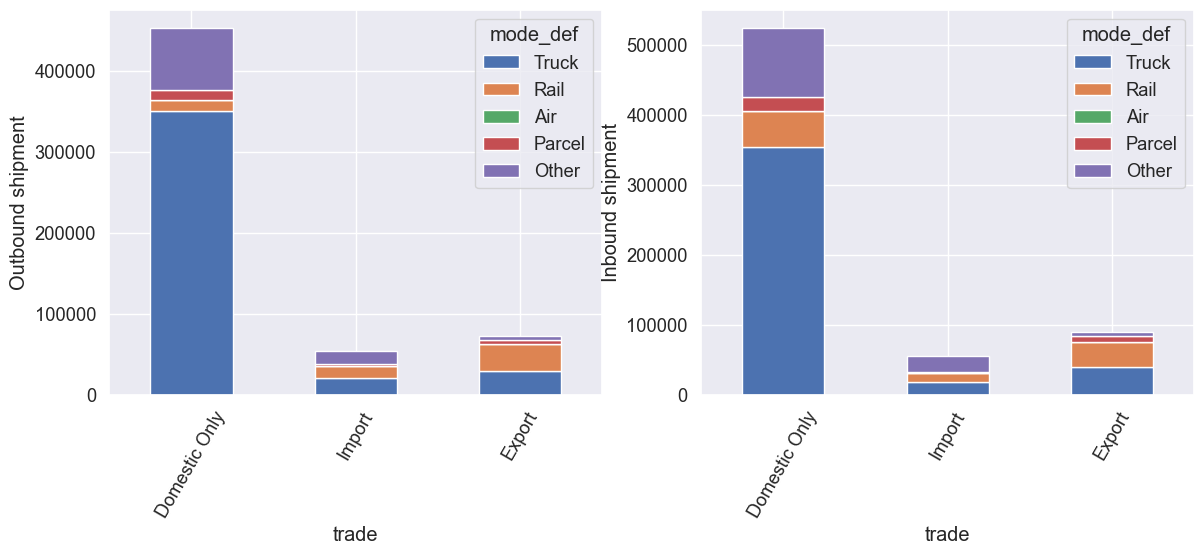

In [9]:
plt.figure(figsize = (14, 5))
plt.tight_layout()
ax1 = plt.subplot(121)
outflow_by_mode_plot = outflow_by_mode[['Truck', 'Rail', 'Air',	'Parcel', 'Other', 'trade']]
outflow_by_mode_plot.plot.bar(x = 'trade', stacked = True, ax = ax1)
ax1.set_ylabel('Outbound shipment')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=60)
ax2 = plt.subplot(122)
inflow_by_mode_plot = inflow_by_mode[['Truck', 'Rail', 'Air',	'Parcel', 'Other', 'trade']]
inflow_by_mode_plot.plot.bar(x = 'trade', stacked = True, ax = ax2)
ax2.set_ylabel('Inbound shipment')
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=60)
plt.savefig(plot_dir  + 'FAF_mode_split.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [15]:
outflow_by_mode_plot.loc[:, 'sum'] = \
outflow_by_mode_plot.loc[:, ['Truck', 'Rail', 'Air', 'Parcel', 'Other']].sum(axis = 1)

outflow_by_mode_plot.loc[:, ['Truck', 'Rail', 'Air', 'Parcel', 'Other']] = 100 * \
outflow_by_mode_plot.loc[:, ['Truck', 'Rail', 'Air', 'Parcel', 'Other']].div(
    outflow_by_mode_plot.loc[:, 'sum'], axis = 0)

outflow_by_mode_plot = outflow_by_mode_plot.drop(columns = ['sum'])

inflow_by_mode_plot.loc[:, 'sum'] = \
inflow_by_mode_plot.loc[:, ['Truck', 'Rail', 'Air', 'Parcel', 'Other']].sum(axis = 1)

inflow_by_mode_plot.loc[:, ['Truck', 'Rail', 'Air', 'Parcel', 'Other']] = 100 * \
inflow_by_mode_plot.loc[:, ['Truck', 'Rail', 'Air', 'Parcel', 'Other']].div(
    inflow_by_mode_plot.loc[:, 'sum'], axis = 0)
inflow_by_mode_plot = inflow_by_mode_plot.drop(columns = ['sum'])

inflow_by_mode_plot.head(5)

mode_def,Truck,Rail,Air,Parcel,Other,trade
0,67.532312,9.874986,0.005500,3.786743,18.800458,Domestic Only
1,32.726373,22.767134,0.090749,2.944736,41.471009,Import
2,43.647628,40.473568,0.037327,9.899234,5.942244,Export


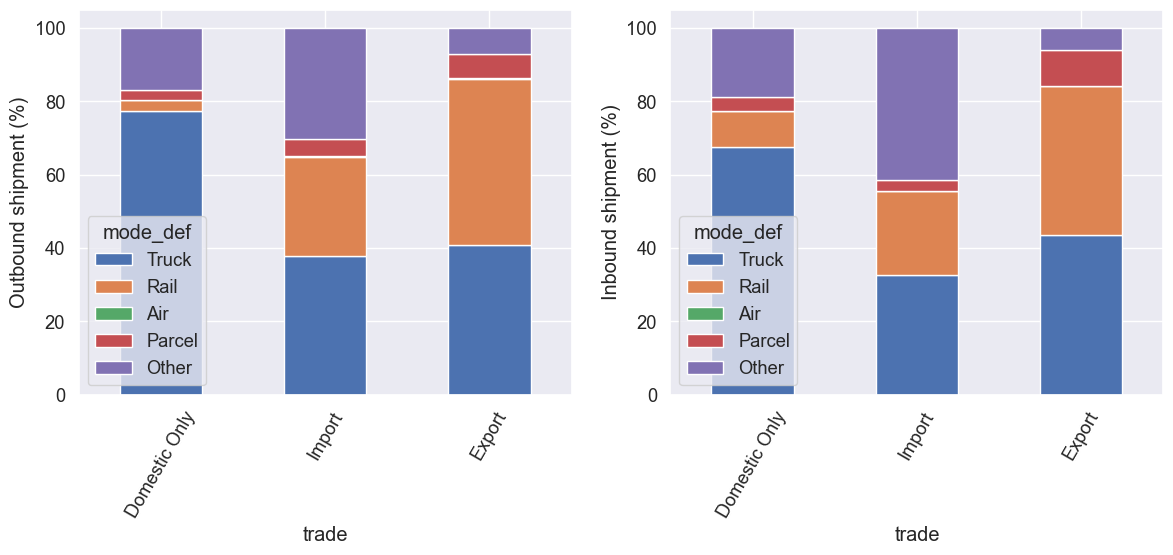

In [16]:
plt.figure(figsize = (14, 5))
plt.tight_layout()
ax1 = plt.subplot(121)

outflow_by_mode_plot.plot.bar(x = 'trade', stacked = True, ax = ax1)
ax1.set_ylabel('Outbound shipment (%)')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=60)
ax2 = plt.subplot(122)

inflow_by_mode_plot.plot.bar(x = 'trade', stacked = True, ax = ax2)
ax2.set_ylabel('Inbound shipment (%)')
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=60)
plt.savefig(plot_dir  + 'FAF_mode_split_percent.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# Compare 2017 vs 2050 production

In [10]:
# Compare domestic/international tonnage
# Seattle only

selected_region = 531
trade_type_lookup = {1: 'Domestic Only', 2: 'Import', 3: 'Export'}
outflow_by_trade = \
faf_outflow.groupby(['dms_orig', 'trade_type', 'SCTG_Name'])[[shipment_load_attr, future_load_attr]].sum()

outflow_by_trade = outflow_by_trade.reset_index()
outflow_by_trade.rename(columns = {'dms_orig': 'region'}, inplace = True)
outflow_by_trade.loc[:, 'type'] = 'Outbound'
outflow_by_trade.loc[:, 'trade'] = \
outflow_by_trade.loc[:, 'trade_type'].map(trade_type_lookup)

inflow_by_trade = \
faf_inflow.groupby(['dms_dest', 'trade_type', 'SCTG_Name'])[[shipment_load_attr, future_load_attr]].sum()
inflow_by_trade = inflow_by_trade.reset_index()
inflow_by_trade.rename(columns = {'dms_dest': 'region'}, inplace = True)
inflow_by_trade.loc[:, 'type'] = 'Inbound'
inflow_by_trade.loc[:, 'trade'] = \
inflow_by_trade.loc[:, 'trade_type'].map(trade_type_lookup)

final_flow_by_trade = pd.concat([outflow_by_trade, inflow_by_trade])
final_flow_by_trade.head(5)

,region,trade_type,SCTG_Name,tons_2017,tons_2050,type,trade
0,411,1,bulk,43882.978462,77398.307761,Outbound,Domestic Only
1,411,1,fuel_fert,14166.306036,20902.423434,Outbound,Domestic Only
2,411,1,interm_food,13873.923029,23508.650852,Outbound,Domestic Only
3,411,1,mfr_goods,15972.187031,26870.693173,Outbound,Domestic Only
4,411,1,other,8376.077975,10239.256699,Outbound,Domestic Only


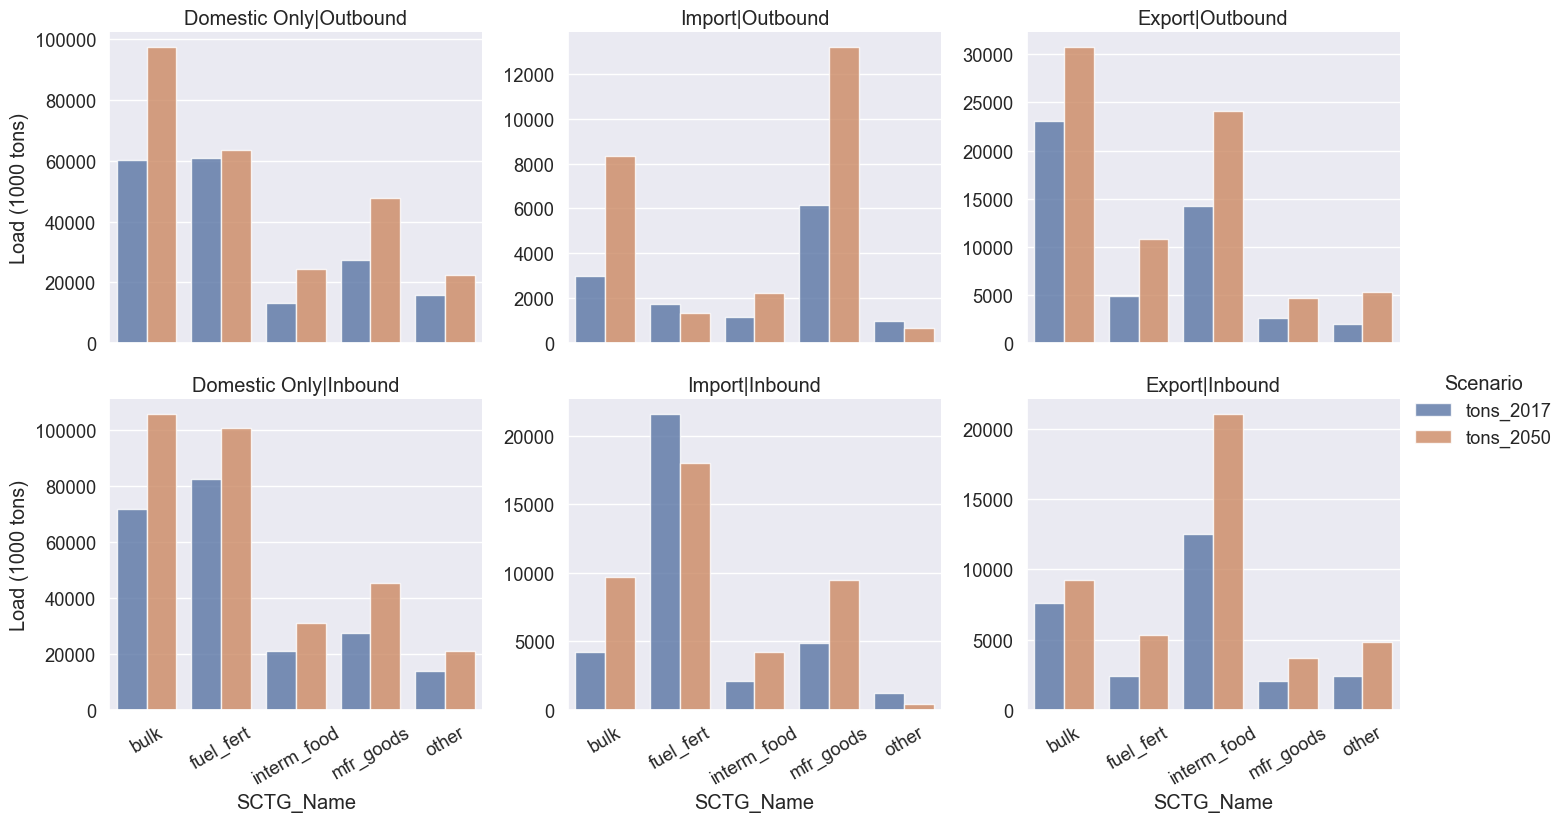

In [19]:
# plot regional results
region_flow_by_trade = \
final_flow_by_trade.loc[final_flow_by_trade['region'] == selected_region]

region_flow_by_trade = pd.melt(region_flow_by_trade,
                              id_vars = ['region', 'SCTG_Name', 'trade', 'type'],
                              value_vars = [shipment_load_attr, future_load_attr],
                              var_name = 'Scenario', value_name = 'Load (1000 tons)')
region_flow_by_trade = region_flow_by_trade.reset_index()
region_flow_by_trade.head(5)
ax = sns.catplot(
    data= region_flow_by_trade, kind="bar", x = 'SCTG_Name',
    hue="Scenario", y='Load (1000 tons)', 
    col = 'trade', row = 'type', 
    alpha=.8, height=4, aspect=1.2, sharey = False
)
ax.set_titles('{col_name}|{row_name}')
for axn in ax.axes.flat:
    for label in axn.get_xticklabels():
        label.set_rotation(30)
plt.savefig(plot_dir + 'forecast_FAF_load_by_trade_type.png', dpi = 300)
plt.show()
final_flow_by_trade.to_csv(output_dir + 'forecast_FAF_load_by_trade_type.csv')